# Location Intelligence Data Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
np.random.seed = 42

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./DATA/google_places_data.csv')

# Feature Engineering

#### Deleting duplicated rows

In [3]:
df = df.drop_duplicates(subset=['business_id'])

#### Outliers

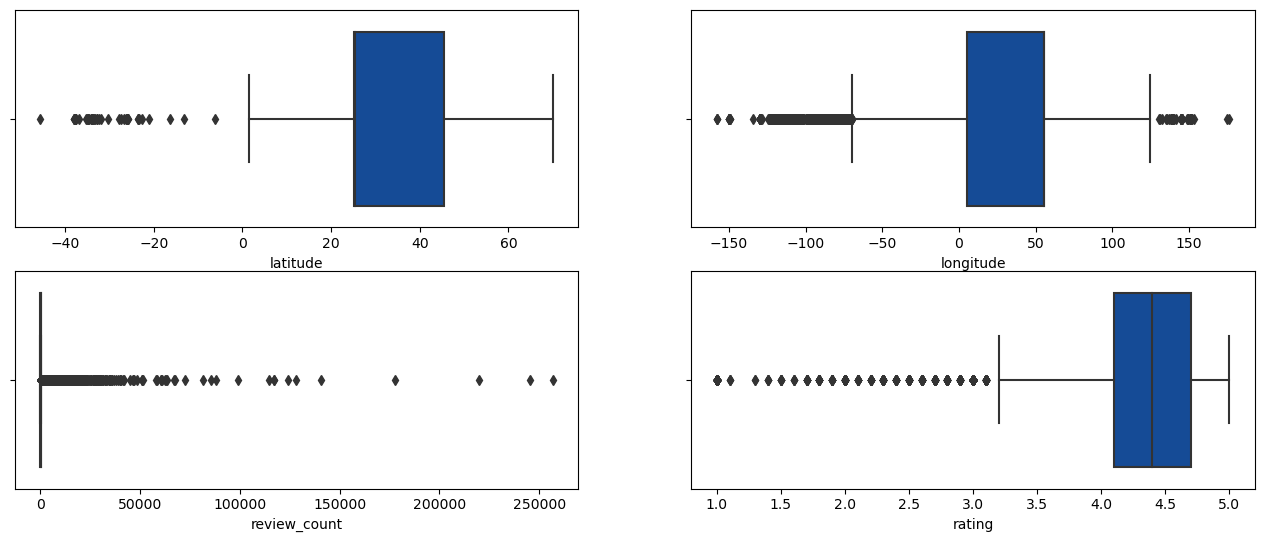

In [4]:
plt.figure(figsize = (16,13))

for i, col in enumerate(['latitude', 'longitude', 'review_count', 'rating']):
    plt.subplot(4,2,i+1)
    sns.boxplot(x = col, data = df, color='#0047AB')
plt.show()

##### Cutting off review_count

In [5]:
review_count_count = df["review_count"].value_counts().reset_index(name='count')
review_count_count = review_count_count[review_count_count['count'] > 100]
review_count_count

,review_count,count
0,32.0,2738
1,1.0,1055
2,2.0,713
3,3.0,543
4,4.0,412
5,5.0,334
6,6.0,255
7,7.0,252
8,8.0,236
9,9.0,218


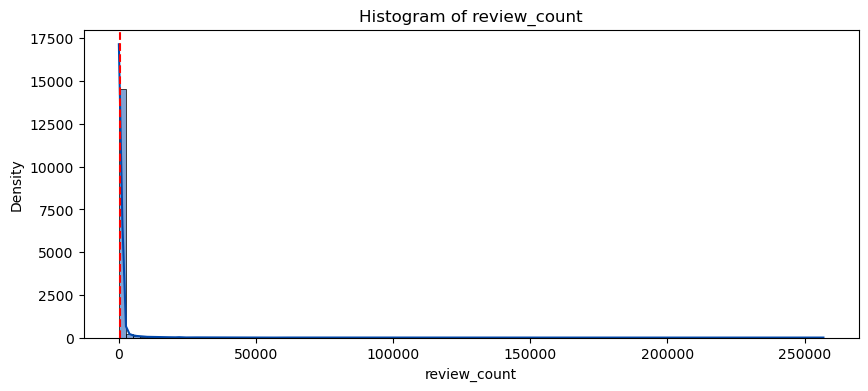

Value above which highest 10% of the data falls: 565.0


In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')

highest_10_percent = df['review_count'].quantile(0.90)
plt.axvline(x=highest_10_percent, color='red', linestyle='--')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()
print("Value above which highest 10% of the data falls:", highest_10_percent)

In [7]:
df.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent

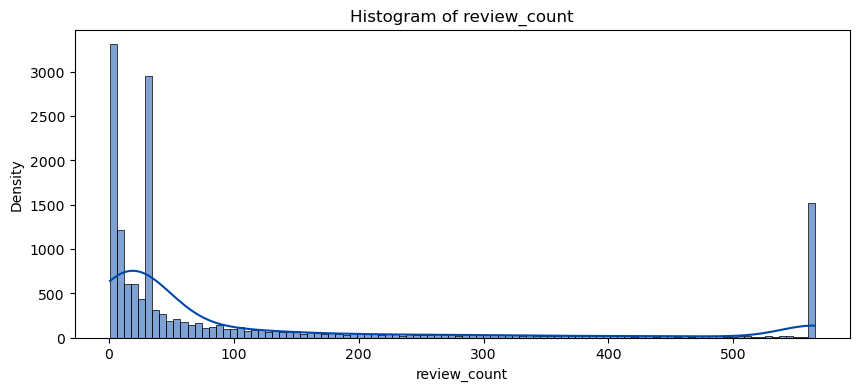

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(df['review_count'], bins=100, kde=True, color='#0047AB', edgecolor='black')
plt.title('Histogram of review_count')
plt.xlabel('review_count')
plt.ylabel('Density')
plt.show()

### Dividing types column

In [9]:
# df_expanded = df.copy()
# df_expanded = df_expanded['types'].str.split(', ', expand=True)
# row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
# df["type_list"] = row_list
# #X = X_train.explode('type_list', ignore_index = True)
# one_hot_encoded  = pd.get_dummies(df.explode('type_list', ignore_index = True)['type_list'])
# joined_df = df.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
# types_columns = joined_df.groupby("business_id", as_index=False).any()

# df_expanded = df.copy()
# df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
# type_counts = df_expanded['type'].value_counts().reset_index()
# type_counts.columns = ['Type', 'Count']
# type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
# unique_types = type_counts["Type"].unique()
# columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
# types_columns = types_columns.drop(columns=columns_to_drop)

# df = pd.merge(df, types_columns, on='business_id')
# df = df.drop(columns=['type_list'])
# df.head()

#### Column removal

In [10]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
business_id,15108
phone_number,11282
name,14192
full_address,14737
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7530


In [11]:
df = df.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])

Some categorical columns have values that are mostly unique to each record in the dataset. As a result, they will not be valuable for our model and we decided to remove them. 

Removed columns: 
* business_id
* phone_number	
* name	
* full_address 
* place_id 
* place_link	

In [12]:
df = df.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening'])

From the EDA stage, we know that the columns related to business operating hours are highly correlated with each other, so we have decided to remove these columns as well.

In [13]:
df = df.drop(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The opening time is not important for our business problem, so we will delete all columns related to opening time.

In [14]:
df = df.drop(columns=['geo_cluster'])

We decided to remove the geo_cluster column, which resulted from a previous clustering performed on the data.

In [15]:
df = df.drop(columns=['state'])

The "state" column indicates whether a given business is open or closed at the time of data collection and how much time remains until this changes. This column is not relevant for clustering, so we have decided to remove it.

In [16]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
latitude,14418
longitude,14422
review_count,550
rating,40
timezone,112
website,7530
types,4082
city,1964
verified,2
country,194


##### website

In [17]:
df['has_website'] = df['website'].apply(lambda x: 0 if x == 'Unknown' else 1)

In [18]:
has_website_count = df["has_website"].value_counts().reset_index(name='count')
has_website_count

,has_website,count
0,1,8865
1,0,6243


##### country

In [19]:
def extract_country(city_country):
    if ',' in city_country:
        return city_country.split(',')[1].strip()
    if '-' in city_country:
        return city_country.split('-')[1].strip() 
    else:
        return city_country

def replace_two_letter_words(text):
    pattern = r'\b[A-Z]{2}\b'
    result = re.sub(pattern, 'USA', text)
    return result

In [20]:
df['country'] = df['country'].apply(lambda x: extract_country(x))
df['country'] = df['country'].apply(lambda x: replace_two_letter_words(x))
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9521
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
...,...,...
76,North Macedonia,1
77,Türkiye,1
78,Ghana,1
79,Latvia,1


In [21]:
category_counts = df['country'].value_counts()
rare_categories = category_counts[category_counts < 10].index
df['country'] = df['country'].apply(lambda x: 'Other' if x in rare_categories or x == 'Unknown' else x)
country_count = df["country"].value_counts().reset_index(name='count')
country_count

,country,count
0,United Arab Emirates,9521
1,USA,1708
2,Netherlands,1490
3,Germany,1127
4,United Kingdom,762
5,Other,206
6,Canada,90
7,Belgium,53
8,Russia,40
9,Australia,26


In [22]:
df = df.drop(columns=['country'])

This is still too many category (country) so we decide to not use column country as well as column city, but we will use more global column continent.

##### timezone

In [23]:
df['timezone']

0           Asia/Dubai
1           Asia/Dubai
2          Asia/Muscat
3        Europe/London
4        Europe/London
             ...      
15198       Asia/Dubai
15199       Asia/Dubai
15200       Asia/Dubai
15201       Asia/Dubai
15202       Asia/Dubai
Name: timezone, Length: 15108, dtype: object

In [24]:
df['continent'] = df['timezone'].str.split('/').str[0]

In [25]:
df['continent'] = df['continent'].apply(lambda x: 'America' if x == 'Pacific' else x)
continent_count = df["continent"].value_counts().reset_index(name='count')
continent_count

,continent,count
0,Asia,9456
1,Europe,3612
2,America,1997
3,Australia,27
4,Africa,16


##### types

In [26]:
df['types']

0                                                   Museum
1                                                   Museum
2              National museum, Museum, Tourist attraction
3        Science museum, Heritage museum, Museum, Touri...
4              Open air museum, Museum, Tourist attraction
                               ...                        
15198                                    Van rental agency
15199                                    Car rental agency
15200                                  Car leasing service
15201                                    Car rental agency
15202                                    Car rental agency
Name: types, Length: 15108, dtype: object

In [27]:
def preprocess_text(text):
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [28]:
df['cleaned_types'] = df['types'].apply(lambda x: preprocess_text(x))
df['cleaned_types']

0                                                   museum
1                                                   museum
2                national museum museum tourist attraction
3        science museum heritage museum museum tourist ...
4                open air museum museum tourist attraction
                               ...                        
15198                                    van rental agency
15199                                    car rental agency
15200                                  car leasing service
15201                                    car rental agency
15202                                    car rental agency
Name: cleaned_types, Length: 15108, dtype: object

In [29]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned_types'])

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

In [31]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [32]:
# assign clusters and pca vectors to our dataframe 
df['cluster_type'] = clusters
df['x0'] = x0
df['x1'] = x1
df[['types', 'cluster_type', 'x0', 'x1']]

,types,cluster_type,x0,x1
0,Museum,3,-0.046576,0.022331
1,Museum,3,-0.046576,0.022331
2,"National museum, Museum, Tourist attraction",3,-0.075184,0.034548
3,"Science museum, Heritage museum, Museum, Touri...",3,-0.072962,0.033686
4,"Open air museum, Museum, Tourist attraction",3,-0.078614,0.035527
...,...,...,...,...
15198,Van rental agency,2,-0.245126,-0.307048
15199,Car rental agency,2,-0.338440,-0.447805
15200,Car leasing service,0,-0.113823,-0.096728
15201,Car rental agency,2,-0.338440,-0.447805


In [33]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
pharmacy,station,bank,salon,laundry,park,bakery,atm,service,hotel

Cluster 1
coffee,shop,pizza,indian,delivery,fast,bar,food,cafe,restaurant

Cluster 2
tour,insurance,used,estate,real,dealer,rental,travel,car,agency

Cluster 3
amusement,state,theme,aquarium,art,zoo,park,museum,attraction,tourist

Cluster 4
pet,grocery,hardware,jewelry,electronics,furniture,shoe,book,clothing,store


In [34]:
#pip install transformers torch scikit-learn

In [35]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from transformers import BertModel, BertTokenizer
import torch
from collections import Counter
import re

# Initialize BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def embed_text(text, tokenizer, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    # Get the hidden states from BERT
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token's embedding
    return embeddings.squeeze().numpy()

# Embed all documents
embeddings = []
for text in df['cleaned_types']:
    embeddings.append(embed_text(text, tokenizer, model))

# Convert the list of embeddings to a numpy array
X = torch.stack(embeddings).numpy()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

def get_top_keywords(n_terms):
    """This function returns the top keywords for each cluster."""
    df['cluster'] = clusters
    for i in range(len(set(clusters))):
        cluster_texts = df[df['cluster'] == i]['cleaned_types']
        all_words = ' '.join(cluster_texts).lower()
        all_words = re.findall(r'\b\w+\b', all_words)  # Extract words
        common_words = Counter(all_words).most_common(n_terms)
        top_keywords = [word for word, count in common_words]
        print(f'\nCluster {i}')
        print(', '.join(top_keywords))

# Call the function to print the top keywords for each cluster
get_top_keywords(10)


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

### Train, Validation and Test Sets

In [51]:
df = pd.read_csv('./DATA/google_places_data.csv')

In [52]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_val = train_test_split(X_dev, test_size=0.3, random_state=42)

### Feature engineering pipeline

In [53]:
def cutOffReviewCount(data):
    highest_10_percent = data['review_count'].quantile(0.90)
    data.loc[df['review_count'] > highest_10_percent, 'review_count'] = highest_10_percent
    return data

def dropDuplicatedRows(data):
    data = data.drop_duplicates(subset=['business_id'])
    return data

def hasWebsite(data):
    data['has_website'] = data['website'].apply(lambda x: 0 if x == 'Unknown' else 1)
    data = data.drop(columns=['website'])
    return data

def dropCountryandCityColumn(data):
    data = data.drop(columns=['country'])
    data = data.drop(columns=['city'])
    return data

def continentColumn(data):
    data['continent'] = data['timezone'].str.split('/').str[0]
    data['continent'] = data['continent'].apply(lambda x: 'America' if x == 'Pacific' else x)
    data = data.drop(columns=['timezone'])
    return data
    
# def divingTypesColumn(data):
#     df_expanded = data.copy()
#     df_expanded = df_expanded['types'].str.split(', ', expand=True)
#     row_list = [df_expanded.iloc[i].tolist() for i in range(len(df_expanded))]
#     data["type_list"] = row_list
#     one_hot_encoded  = pd.get_dummies(data.explode('type_list', ignore_index = True)['type_list'])
#     joined_df = data.explode('type_list', ignore_index = True).join(one_hot_encoded, lsuffix='_left', rsuffix='_right')
#     types_columns = joined_df.groupby("business_id", as_index=False).any()
    
#     df_expanded = data.copy()
#     df_expanded = df_expanded['types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='type')
#     type_counts = df_expanded['type'].value_counts().reset_index()
#     type_counts.columns = ['Type', 'Count']
#     type_counts = type_counts[type_counts['Count'] > 50] # można zwiększyć próg, aby było mniej kolumn
#     unique_types = type_counts["Type"].unique()
#     columns_to_drop = [col for col in types_columns.columns if (col not in unique_types and col not in ["business_id"])]
#     types_columns = types_columns.drop(columns=columns_to_drop)
    
#     data = pd.merge(data, types_columns, on='business_id')
#     data = data.drop(columns=['type_list'])
#     return data

def dropUniqueColumns(data):
    data = data.drop(columns=['business_id', 'phone_number', 'name', 'full_address', 'place_id', 'place_link'])
    return data

def dropDayTimeColumns(data):
    data = data.drop(columns=['Monday_morning', 'Monday_afternoon', 'Monday_evening',
                'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
                'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
                'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
                'Friday_morning', 'Friday_afternoon', 'Friday_evening',
                'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
                'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening',
                'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    return data

def dropGeoClusterAndState(data):
    data = data.drop(columns=['geo_cluster', 'state'])
    return data


feature_engineering_pipeline = Pipeline([
    ('cutOffReviewCount', FunctionTransformer(cutOffReviewCount)),
    ('dropDuplicatedRows', FunctionTransformer(dropDuplicatedRows)),
    ('hasWebsite', FunctionTransformer(hasWebsite)),
    ('dropCountryandCityColumn', FunctionTransformer(dropCountryandCityColumn)),
    ('continentColumn', FunctionTransformer(continentColumn)),
    #('divingTypesColumn', FunctionTransformer(divingTypesColumn)),
    ('dropUniqueColumns', FunctionTransformer(dropUniqueColumns)),
    ('dropDayTimeColumns', FunctionTransformer(dropDayTimeColumns)),
    ('dropGeoClusterAndState', FunctionTransformer(dropGeoClusterAndState))
])

In [54]:
X_train = feature_engineering_pipeline.transform(X_train)

In [55]:
X_train

,latitude,longitude,review_count,rating,types,verified,has_website,continent
7362,50.114052,8.685846,9.0,4.4,Travel agency,True,1,Europe
10971,25.271356,55.316515,20.0,4.7,Mosque,False,0,Asia
4882,25.312023,55.456259,35.0,4.3,Bicycle Shop,True,0,Asia
10205,25.268352,55.306795,19.0,3.9,Electronics store,True,0,Asia
6103,25.204849,55.270783,32.0,4.4,University,False,0,Asia
...,...,...,...,...,...,...,...,...
802,52.158834,5.382056,32.0,4.4,ATM,False,1,Europe
14546,38.893988,-77.036582,500.0,4.4,"Park, Tourist attraction",False,1,America
15024,25.321703,55.520428,2.0,5.0,Car rental agency,True,0,Asia
10440,25.298560,55.372075,32.0,4.4,Restaurant,True,0,Asia
